## Загрузим нужные библиотеки

# Задача.

### Разработать и обучить модель на основе метаданных поведения пользователя в игре и его итоговой экспертной оценки. Прогнозировать оценки участникам симуляции без привлечения экспертов.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import math
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)

В этом примере мы попробуем предсказать итоговую оценку участинка только на основе **его действий**

In [2]:
df_train = pd.read_csv("train.csv")
df_user = pd.read_csv("user_decision.csv")

In [3]:
pd.DataFrame(df_user.groupby('user_id')['decision_id'].value_counts())

decision_id
user_id decision_id             
10001   25                     8
        26                     8
        27                     8
        31                     3
        32                     3
...                          ...
10973   304                    1
        306                    1
        344                    1
        386                    1
        427                    1

[44663 rows x 1 columns]

## Рассмотрим датасет по ближе

In [4]:
df_train.shape


(680, 5)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   680 non-null    int64  
 1   Analytical thinking  680 non-null    float64
 2   Systemic thinking    680 non-null    float64
 3   Adaptability         680 non-null    float64
 4   Focus                680 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 26.7 KB


In [6]:
df_train.head(30)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0
5,10908,4.0,4.0,5.0,5.0
6,10378,4.0,5.0,5.0,4.0
7,10220,5.0,4.0,5.0,5.0
8,10612,5.0,4.0,4.0,5.0
9,10776,4.0,4.0,5.0,5.0


In [7]:
df_train.describe()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
count,680.000000,680.000000,680.000000,680.000000,680.000000
mean,10486.089706,4.277941,4.119118,4.447059,4.308824
std,281.738218,0.647266,0.596197,0.664804,0.608176
min,10001.000000,1.000000,1.000000,1.000000,1.000000
25%,10233.750000,4.000000,4.000000,4.000000,4.000000
50%,10491.500000,4.000000,4.000000,4.000000,4.000000
75%,10729.250000,5.000000,4.000000,5.000000,5.000000
max,10973.000000,6.000000,6.000000,6.000000,6.000000


In [8]:
df_user.shape

(60228, 3)

In [9]:
df_user.head(3)

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420


In [10]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60228 entries, 0 to 60227
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      60228 non-null  int64
 1   period       60228 non-null  int64
 2   decision_id  60228 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


Заметим что в есть категория где пользватель совершал больше действий

In [11]:
df_user.period.value_counts()

3    20964
4    14811
2    14453
1    10000
Name: period, dtype: int64

Пострим на распределение данных

### Добавим новых значений

Узнаем частоту команд участника в каждом периоде

In [14]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in df_train.id.values)]
df_user_train

,user_id,period,decision_id
0,10625,1,409
2,10775,4,420
3,10236,2,284
4,10130,3,72
5,10273,2,140
...,...,...,...
60220,10528,1,88
60222,10832,3,315
60224,10189,1,33
60226,10424,2,140


In [15]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [16]:
df_decision_count.head(5)

decision_id
user_id period             
10001   1                29
        2                23
        3                39
        4                15
10003   1                21

In [17]:
for id in df_train.id.values:
  for period in range(1,5):
    try :
      index = df_train[df_train.id == id].index[0]
      df_train.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]

    except IndexError:
      continue

In [18]:
df_train['Adaptability']=df_train['Adaptability'].fillna(df_train['Adaptability'].mean())
df_train=df_train.fillna(df_train.median())

In [19]:
df_decision_count_id = pd.DataFrame(df_user_train.groupby('user_id')['decision_id'].value_counts())
df_decision_count_id = df_decision_count_id.rename(columns={'decision_id': 'decision'})
df_decision_count_id.query('user_id==10001').shape

(64, 1)

for id in df_train.id.values:
  for period in range(1,343):
    try :
      index = df_train[df_train.id == id].index[0]
      df_train.loc[index,"decision_id"+str(period)] = pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()[pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()['decision_id'] == period]['decision'].values[0]
    except IndexError:
      continue

df_train.to_csv('df_trainmonstr.csv',index=False)

In [20]:
#df_train=pd.read_csv('df_trainmonstr.csv')

In [21]:
df_train=df_train.fillna(0)

## Распределение  оценок в тренеровочном наборе.

Text(0.5, 1.0, 'Analytical thinking оценки колличество')

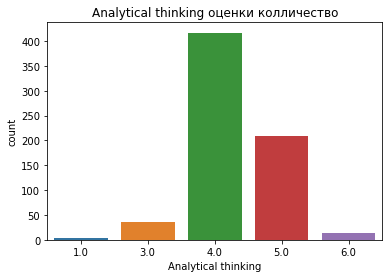

In [22]:
sns.countplot(x = "Analytical thinking" , data  = df_train).set_title('Analytical thinking оценки колличество')

Text(0.5, 1.0, 'Systemic thinking оценки колличество')

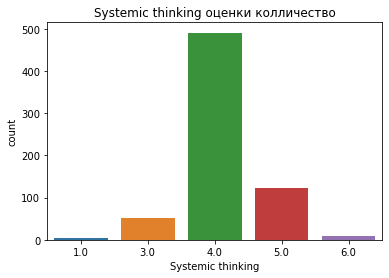

In [23]:
sns.countplot(x = "Systemic thinking" , data  = df_train).set_title('Systemic thinking оценки колличество')

Text(0.5, 1.0, 'Adaptability оценки колличество')

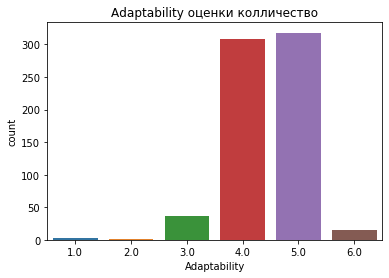

In [24]:
sns.countplot(x = "Adaptability" , data  = df_train).set_title('Adaptability оценки колличество')

Text(0.5, 1.0, 'Focus оценки колличество')

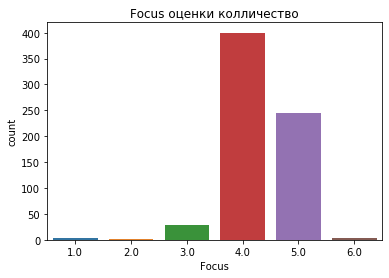

In [25]:
sns.countplot(x = "Focus" , data  = df_train).set_title('Focus оценки колличество')

## Добавили фичи

In [26]:
df_train['sum']=df_train['period_1']+df_train['period_2']+df_train['period_3']+df_train['period_4']
df_train['quad']=df_train['period_1'] * df_train['period_1'] + df_train['period_2'] * df_train['period_2'] + df_train['period_3'] * df_train['period_3'] + df_train['period_4'] * df_train['period_4']
df_train['medan']=(df_train['period_1']+df_train['period_2']+df_train['period_3']+df_train['period_4'])/4
df_train['sqr_median']=np.sqrt(df_train['medan'])
df_train['sqr_sum']=np.sqrt(df_train['sum'])

In [27]:
df_train=df_train.sort_index(axis = 1)
 

In [28]:
df_train

,Adaptability,Analytical thinking,Focus,Systemic thinking,id,medan,period_1,period_2,period_3,period_4,quad,sqr_median,sqr_sum,sum
0,4.0,4.0,4.0,4.0,10884,14.75,7.0,14.0,28.0,10.0,1129.0,3.840573,7.681146,59.0
1,5.0,5.0,5.0,4.0,10106,15.50,21.0,21.0,12.0,8.0,1090.0,3.937004,7.874008,62.0
2,5.0,6.0,5.0,5.0,10438,52.00,62.0,45.0,63.0,38.0,11282.0,7.211103,14.422205,208.0
3,5.0,5.0,5.0,4.0,10130,38.50,26.0,28.0,34.0,66.0,6972.0,6.204837,12.409674,154.0
4,5.0,4.0,5.0,5.0,10667,89.25,58.0,70.0,194.0,35.0,47125.0,9.447222,18.894444,357.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,5.0,5.0,4.0,4.0,10563,7.50,10.0,2.0,14.0,4.0,316.0,2.738613,5.477226,30.0
676,5.0,5.0,5.0,4.0,10386,10.00,1.0,14.0,24.0,1.0,774.0,3.162278,6.324555,40.0
677,5.0,5.0,4.0,4.0,10675,14.00,4.0,17.0,23.0,12.0,978.0,3.741657,7.483315,56.0
678,4.0,4.0,4.0,4.0,10366,34.25,10.0,44.0,45.0,38.0,5505.0,5.852350,11.704700,137.0


## Балансировка датасета, из за маленького кол ва некоторых оценок, оказалась сложной задачей, стандартные методы не дали результата. В итоге применили простое удвоение.

In [29]:
df_train=df_train.append(df_train)

In [30]:

df_train['Focus'].value_counts()

4.0    800
5.0    488
3.0     58
6.0      6
1.0      6
2.0      2
Name: Focus, dtype: int64


focus1=df_train.query("Adaptability==2").head()
focus2=df_train.query("Adaptability==1").head()
focus3=df_train.query("Adaptability==6").head()
focus4=df_train.query("Adaptability==3").head()
for i in range(1,10):
    df_train=df_train.append(focus1, ignore_index=True)
    df_train=df_train.append(focus2, ignore_index=True)
    df_train=df_train.append(focus3, ignore_index=True)
    df_train=df_train.append(focus4, ignore_index=True)

In [31]:
df_train['Adaptability'].value_counts()

5.0    636
4.0    616
3.0     72
6.0     30
1.0      4
2.0      2
Name: Adaptability, dtype: int64

In [32]:
df_train=df_train.query('Adaptability!=2')
df_train=df_train.query('Focus!=2')

In [33]:
df_train

,Adaptability,Analytical thinking,Focus,Systemic thinking,id,medan,period_1,period_2,period_3,period_4,quad,sqr_median,sqr_sum,sum
0,4.0,4.0,4.0,4.0,10884,14.75,7.0,14.0,28.0,10.0,1129.0,3.840573,7.681146,59.0
1,5.0,5.0,5.0,4.0,10106,15.50,21.0,21.0,12.0,8.0,1090.0,3.937004,7.874008,62.0
2,5.0,6.0,5.0,5.0,10438,52.00,62.0,45.0,63.0,38.0,11282.0,7.211103,14.422205,208.0
3,5.0,5.0,5.0,4.0,10130,38.50,26.0,28.0,34.0,66.0,6972.0,6.204837,12.409674,154.0
4,5.0,4.0,5.0,5.0,10667,89.25,58.0,70.0,194.0,35.0,47125.0,9.447222,18.894444,357.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,5.0,5.0,4.0,4.0,10563,7.50,10.0,2.0,14.0,4.0,316.0,2.738613,5.477226,30.0
676,5.0,5.0,5.0,4.0,10386,10.00,1.0,14.0,24.0,1.0,774.0,3.162278,6.324555,40.0
677,5.0,5.0,4.0,4.0,10675,14.00,4.0,17.0,23.0,12.0,978.0,3.741657,7.483315,56.0
678,4.0,4.0,4.0,4.0,10366,34.25,10.0,44.0,45.0,38.0,5505.0,5.852350,11.704700,137.0


## Выделим выборки

In [34]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Analytical thinking']

In [35]:
X.shape

(1358, 9)

In [36]:
X

,medan,period_1,period_2,period_3,period_4,quad,sqr_median,sqr_sum,sum
0,14.75,7.0,14.0,28.0,10.0,1129.0,3.840573,7.681146,59.0
1,15.50,21.0,21.0,12.0,8.0,1090.0,3.937004,7.874008,62.0
2,52.00,62.0,45.0,63.0,38.0,11282.0,7.211103,14.422205,208.0
3,38.50,26.0,28.0,34.0,66.0,6972.0,6.204837,12.409674,154.0
4,89.25,58.0,70.0,194.0,35.0,47125.0,9.447222,18.894444,357.0
...,...,...,...,...,...,...,...,...,...
675,7.50,10.0,2.0,14.0,4.0,316.0,2.738613,5.477226,30.0
676,10.00,1.0,14.0,24.0,1.0,774.0,3.162278,6.324555,40.0
677,14.00,4.0,17.0,23.0,12.0,978.0,3.741657,7.483315,56.0
678,34.25,10.0,44.0,45.0,38.0,5505.0,5.852350,11.704700,137.0


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Кореляции

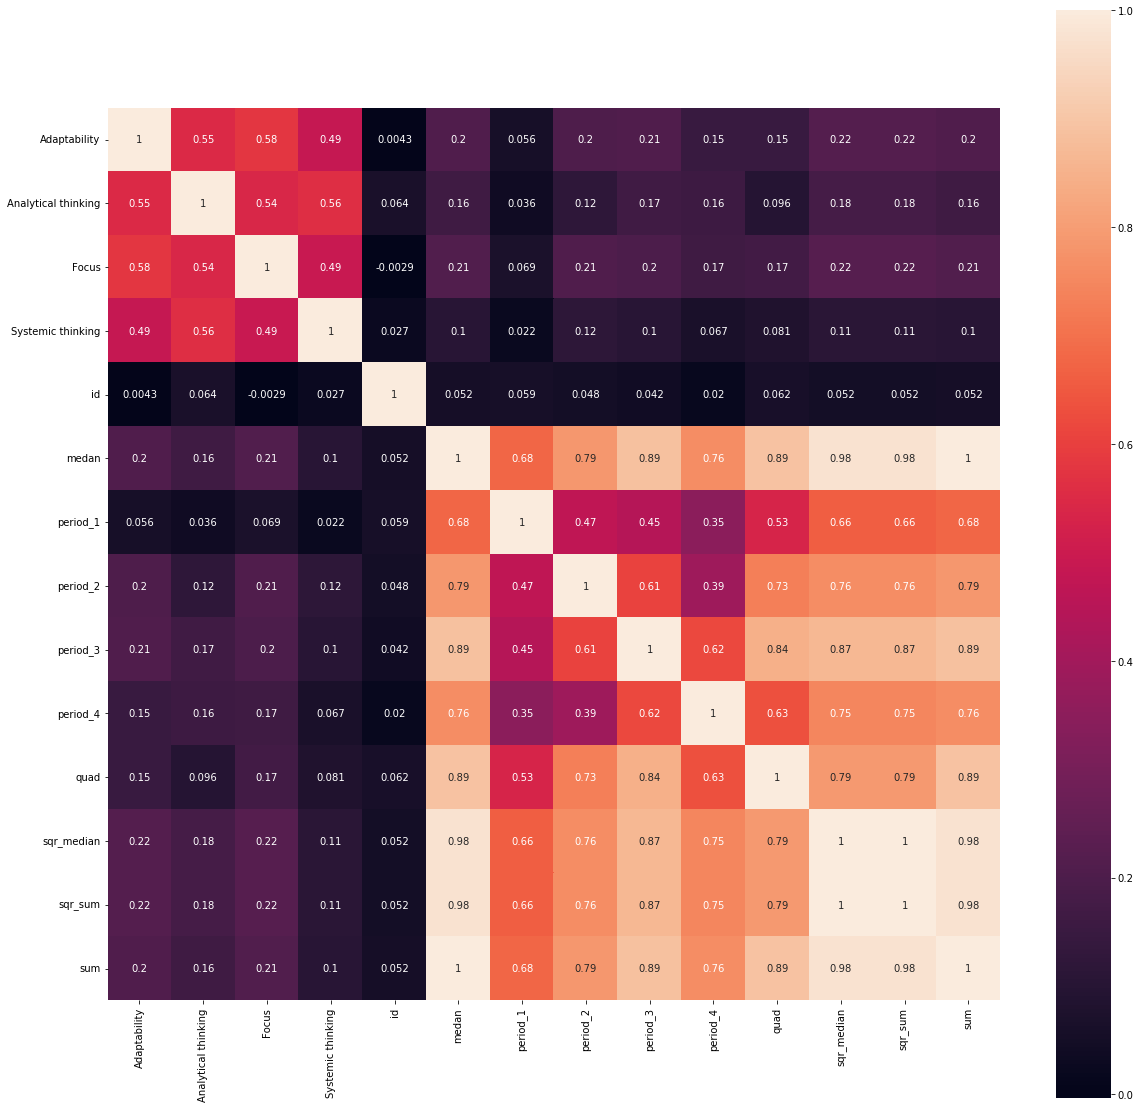

In [38]:
plt.rcParams['figure.figsize']=(20,20)

g = sns.heatmap(df_train.corr(), square = True, annot=True)

## Используем Наи́вный ба́йесовский классифика́тор. Хорошо показывает себя на малых выборках и категориальных данных. 

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
rf_model_Analytical_thinking =  GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Analytical_thinking.fit(X_train, y_train)

GaussianNB()

## Оценка точности

In [40]:
pred = rf_model_Analytical_thinking.predict(X_test)

In [41]:
pred

array([4., 4., 5., 4., 5., 4., 5., 4., 4., 4., 4., 5., 4., 3., 4., 5., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 5., 5., 4., 4., 4., 4., 4., 5., 4., 5., 5., 5., 5., 5., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 4., 5., 4., 4., 4., 4., 5., 5., 4., 4., 4., 4., 4., 4.,
       4., 5., 4., 4., 4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 5., 4., 5., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4.])

In [42]:

print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         5
         4.0       0.69      0.84      0.76        88
         5.0       0.54      0.34      0.42        41
         6.0       0.00      0.00      0.00         2

    accuracy                           0.65       136
   macro avg       0.31      0.30      0.29       136
weighted avg       0.61      0.65      0.61       136



In [43]:
pred = rf_model_Analytical_thinking.predict(X)

In [44]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y=df_train['Systemic thinking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_model_Systemic_thinking =   GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Systemic_thinking.fit(X_train, y_train)
pred = rf_model_Systemic_thinking.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         9
         4.0       0.75      0.91      0.82       102
         5.0       0.25      0.15      0.19        20
         6.0       0.00      0.00      0.00         5

    accuracy                           0.71       136
   macro avg       0.25      0.27      0.25       136
weighted avg       0.60      0.71      0.64       136



In [45]:
pred = rf_model_Systemic_thinking.predict(X)

In [46]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Adaptability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_model_Adaptability =   GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Adaptability.fit(X_train, y_train)
pred = rf_model_Adaptability.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         3.0       0.04      0.17      0.07         6
         4.0       0.51      0.67      0.58        66
         5.0       0.71      0.26      0.38        58
         6.0       0.50      0.17      0.25         6

    accuracy                           0.45       136
   macro avg       0.35      0.25      0.26       136
weighted avg       0.58      0.45      0.46       136



In [47]:
pred = rf_model_Adaptability.predict(X)

In [48]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Focus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_model_Focus =   GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Focus.fit(X_train, y_train)
pred = rf_model_Focus.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.16      0.82      0.26        11
         4.0       0.46      0.38      0.42        71
         5.0       0.68      0.25      0.36        53
         6.0       1.00      1.00      1.00         1

    accuracy                           0.37       136
   macro avg       0.57      0.61      0.51       136
weighted avg       0.53      0.37      0.39       136



In [49]:
# Предикт.

In [50]:
datapre=pd.read_csv('sample_solution.csv')

In [51]:
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [52]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in datapre.id.values)]

In [53]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [54]:
df_decision_count.head(5)

decision_id
user_id period             
10002   2                 9
        3                25
        4                22
10005   1                14
        2                34

In [55]:
for id in datapre.id.values:
  for period in range(1,5):
    try :
      index = datapre[datapre.id == id].index[0]
      datapre.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [56]:
datapre=datapre.fillna(datapre.median())

In [57]:
df_decision_count_id = pd.DataFrame(df_user.groupby('user_id')['decision_id'].value_counts())
df_decision_count_id = df_decision_count_id.rename(columns={'decision_id': 'decision'})
df_decision_count_id.query('user_id==10001').shape

(64, 1)

for id in datapre.id.values:
  for period in range(1,343):
    try :
      index = datapre[datapre.id == id].index[0]
      datapre.loc[index,"decision_id"+str(period)] = pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()[pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()['decision_id'] == period]['decision'].values[0]
    except IndexError:
      continue

datapre=datapre.fillna(0)

datapre

datapre.to_csv('datapremonstr.csv',index=False)

In [58]:
#datapre=pd.read_csv('datapremonstr.csv')
datapre=datapre.sort_index(axis = 1)

In [59]:
datapre

,Adaptability,Analytical thinking,Focus,Systemic thinking,id,period_1,period_2,period_3,period_4
0,0,0,0,0,10199,2.0,2.0,3.0,2.0
1,0,0,0,0,10539,1.0,9.0,15.0,17.0
2,0,0,0,0,10174,9.0,28.0,31.0,20.0
3,0,0,0,0,10465,15.0,18.0,32.0,18.0
4,0,0,0,0,10066,8.0,23.0,16.0,6.0
...,...,...,...,...,...,...,...,...,...
288,0,0,0,0,10433,18.0,7.0,1.0,12.0
289,0,0,0,0,10893,21.0,52.0,34.0,20.0
290,0,0,0,0,10909,9.0,12.0,17.0,1.0
291,0,0,0,0,10889,6.0,2.0,5.0,1.0


In [60]:
datapre['sum']=datapre['period_1']+datapre['period_2']+datapre['period_3']+datapre['period_4']
datapre['quad']=datapre['period_1'] * datapre['period_1'] + datapre['period_2'] * datapre['period_2'] + datapre['period_3'] * datapre['period_3'] + datapre['period_4'] * datapre['period_4']
datapre['medan']=(datapre['period_1']+datapre['period_2']+datapre['period_3']+datapre['period_4'])/4
datapre['sqr_median']=np.sqrt(datapre['medan'])
datapre['sqr_sum']=np.sqrt(datapre['sum'])

In [61]:
datapre=datapre.sort_index(axis = 1)

In [62]:
datapre

,Adaptability,Analytical thinking,Focus,Systemic thinking,id,medan,period_1,period_2,period_3,period_4,quad,sqr_median,sqr_sum,sum
0,0,0,0,0,10199,2.25,2.0,2.0,3.0,2.0,21.0,1.500000,3.000000,9.0
1,0,0,0,0,10539,10.50,1.0,9.0,15.0,17.0,596.0,3.240370,6.480741,42.0
2,0,0,0,0,10174,22.00,9.0,28.0,31.0,20.0,2226.0,4.690416,9.380832,88.0
3,0,0,0,0,10465,20.75,15.0,18.0,32.0,18.0,1897.0,4.555217,9.110434,83.0
4,0,0,0,0,10066,13.25,8.0,23.0,16.0,6.0,885.0,3.640055,7.280110,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,0,0,0,0,10433,9.50,18.0,7.0,1.0,12.0,518.0,3.082207,6.164414,38.0
289,0,0,0,0,10893,31.75,21.0,52.0,34.0,20.0,4701.0,5.634714,11.269428,127.0
290,0,0,0,0,10909,9.75,9.0,12.0,17.0,1.0,515.0,3.122499,6.244998,39.0
291,0,0,0,0,10889,3.50,6.0,2.0,5.0,1.0,66.0,1.870829,3.741657,14.0


In [63]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)

pred_Analytical_thinking = rf_model_Analytical_thinking.predict(X)
pred_Analytical_thinking

array([4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 5., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 4., 4., 4., 5., 5., 5., 4., 4., 5., 5., 4., 4., 4., 4., 5., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5., 4., 5., 4., 4., 4.,
       4., 5., 5., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5.,
       5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4.,
       4., 5., 5., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 4., 4., 5.,
       4., 4., 4., 4., 4.

In [64]:

X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Systemic_thinking = rf_model_Systemic_thinking.predict(X)
pred_Systemic_thinking

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 5., 5., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 4., 5., 6., 4., 4., 4., 4., 5., 4., 4., 4., 4., 6.,
       4., 5., 4., 5., 4., 4., 5., 6., 4., 4., 4., 4., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

In [65]:

X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Adaptability = rf_model_Adaptability.predict(X)
pred_Adaptability

array([3., 4., 4., 4., 4., 3., 5., 4., 3., 3., 4., 4., 4., 4., 3., 4., 4.,
       4., 6., 5., 6., 5., 4., 3., 3., 4., 4., 4., 4., 3., 4., 4., 4., 4.,
       5., 4., 4., 4., 5., 5., 5., 4., 4., 6., 1., 4., 4., 4., 4., 1., 4.,
       4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 5., 5., 4., 4., 4., 4., 6.,
       4., 4., 4., 4., 4., 3., 1., 4., 3., 4., 4., 4., 4., 4., 5., 4., 4.,
       3., 4., 4., 4., 4., 5., 4., 3., 3., 4., 4., 4., 4., 5., 5., 5., 3.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5., 4., 5., 4., 4., 4.,
       4., 6., 5., 5., 4., 4., 1., 5., 4., 4., 3., 4., 4., 6., 4., 4., 4.,
       3., 4., 4., 4., 3., 3., 3., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 5., 4., 4., 4., 3., 1., 4., 4., 4., 4., 4., 6.,
       1., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4.,
       3., 5., 4., 3., 5., 4., 4., 4., 3., 4., 3., 4., 3., 4., 6., 4., 4.,
       5., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 5., 5., 1., 4., 4., 5.,
       4., 3., 4., 3., 4.

In [66]:

X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Focus = rf_model_Focus.predict(X)
len(pred_Focus)

293

In [67]:
datapre=pd.read_csv('sample_solution.csv')
datapre  

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [68]:
datapre['Analytical thinking']=pred_Analytical_thinking
datapre['Systemic thinking']=pred_Systemic_thinking
datapre['Adaptability']=pred_Adaptability
datapre['Focus']=pred_Focus

In [69]:
datapre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   293 non-null    int64  
 1   Analytical thinking  293 non-null    float64
 2   Systemic thinking    293 non-null    float64
 3   Adaptability         293 non-null    float64
 4   Focus                293 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.6 KB


In [70]:
#datapre.to_csv('dataprebs41.csv',index=False)

In [71]:
dataprev=pd.read_csv('dataprebs41.csv')


In [72]:
dataprev.describe()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
count,293.000000,293.000000,293.000000,293.000000,293.000000
mean,10489.112628,4.194539,4.109215,3.969283,3.696246
std,279.832382,0.396523,0.343756,0.791053,0.721409
min,10002.000000,4.000000,4.000000,1.000000,3.000000
25%,10265.000000,4.000000,4.000000,4.000000,3.000000
50%,10482.000000,4.000000,4.000000,4.000000,4.000000
75%,10731.000000,4.000000,4.000000,4.000000,4.000000
max,10972.000000,5.000000,6.000000,6.000000,5.000000


In [73]:
dataprev['Adaptability'].value_counts()

4.0    193
3.0     45
5.0     39
6.0      9
1.0      7
Name: Adaptability, dtype: int64

In [74]:
dataprev['Analytical thinking'].value_counts()

4.0    236
5.0     57
Name: Analytical thinking, dtype: int64

In [75]:
dataprev['Focus'].value_counts()

3.0    134
4.0    114
5.0     45
Name: Focus, dtype: int64

In [76]:
dataprev['Systemic thinking'].value_counts()

4.0    264
5.0     26
6.0      3
Name: Systemic thinking, dtype: int64

In [77]:
datapre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   293 non-null    int64  
 1   Analytical thinking  293 non-null    float64
 2   Systemic thinking    293 non-null    float64
 3   Adaptability         293 non-null    float64
 4   Focus                293 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.6 KB


#### 